In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.options.plotting.backend = "plotly"
import os
from ipywidgets import interact, interactive, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [3]:
path_analysis = 'results/NET-btc530k-heur_1-day'
states = ["ssc","in","out","tubes","tendrils","fringe","disconnected"]

df_raw = pd.read_json(os.path.join(path_analysis,'bt_comp_count.json'),convert_dates=True).transpose()
df_bowtie = df_raw.copy()

#clean df for sunken transactions
df_sunk = df_bowtie[list(map(lambda x: x+ '_s', states))]
df_sunk.columns = states
df_bowtie[states] = df_bowtie[states].subtract(df_sunk)

total_nodes = df_bowtie[states].sum(axis=1)

In [29]:
#absolut number of nodes in components
range_slider = widgets.SelectionRangeSlider(
    options=df_bowtie.index.date, index=(0, len(df_bowtie.index)-1),
    description='Date window', orientation='horizontal', layout={'width': '500px'})

mean_slider = widgets.IntSlider(min=1, max=100, step=1, value=10, 
                                        description='rolling mean')

@interact_manual #@interact
def plot_bt_abs(rolling_mean = mean_slider, date_range = range_slider, scale=['absolute','relative']):
    df_comp = df_bowtie.copy().loc[date_range[0]:date_range[1]][states]
    df_comp.columns.name = 'Bow-tie component'
    if scale == 'relative':
        df_comp = df_comp.div(df_comp.sum(axis=1).values,axis=0)
    df_comp.rolling(window=rolling_mean).mean().plot(title="bow-tie components {}".format(scale)).show()

#interact(plot_bt_abs, window= widgets.IntSlider(min=1, max=100, step=1, value=10))



interactive(children=(IntSlider(value=10, description='rolling mean', min=1), SelectionRangeSlider(description…

In [8]:
#  load markov transition matrices
file = os.path.join(path_analysis, "transition_matrices.json")
states_extened = states + ['inactive']

with open(file, 'r') as tm_file:
    data = tm_file.read()

transition_dict = json.loads(data)

In [30]:
# Show markov transition matrix
range_slider2 = widgets.SelectionRangeSlider(
    options=df_bowtie.index.date, index=(0, len(df_bowtie.index)-1),
    description='Date window', orientation='horizontal', layout={'width': '500px'})

@interact #@interact_manual
def transition_matrix(date_range = range_slider, scale=['relative','absolute'],exclude_inactive=False):
    
    date_from , date_to = date_range[0].strftime('%Y-%m-%d'), date_range[1].strftime('%Y-%m-%d')
    tm_matrix = np.zeros(shape=(len(states_extened),len(states_extened)),dtype=int)
    
    date_index = pd.DataFrame({},index=transition_dict.keys())
    keys = date_index.loc[date_from : date_to].index.values
    
    for key in keys:
        tm = transition_dict[key]
        tm_matrix += np.array(np.array(tm))

    df = pd.DataFrame(tm_matrix, index=states_extened, columns=states_extened)
    if exclude_inactive == True:
        df = df[states][:-1]
    if scale == 'relative':
       df = df.div(df.sum(axis=1).values,axis=0)*100
    display(df.style.background_gradient(cmap='Blues')
            .set_caption("Markov state transition matrix for {} to {} in {} numbers"
                         .format(date_from, date_to, scale)))

interactive(children=(SelectionRangeSlider(description='Date window', index=(0, 3460), layout=Layout(width='50…

In [35]:
range_slider3 = widgets.SelectionRangeSlider(
    options=df_bowtie.index.date, index=(0, len(df_bowtie.index)-1),
    description='Date window', orientation='horizontal', layout={'width': '500px'})

@interact_manual #@interact_manual
def tm_barplot(date_range = range_slider3, scale=['relative','absolute'],
               state = states_extened,exclude_inactive=True ):
    
    date_from , date_to = date_range[0].strftime('%Y-%m-%d'), date_range[1].strftime('%Y-%m-%d')
    tm_matrix = np.zeros(shape=(len(states_extened),len(states_extened)),dtype=int)
    
    date_index = pd.DataFrame({},index=transition_dict.keys())
    keys = date_index.loc[date_from : date_to].index.values
    
    for key in keys:
        tm = transition_dict[key]
        tm_matrix += np.array(np.array(tm))

    df = pd.DataFrame(tm_matrix, index=states_extened, columns=states_extened)
    if exclude_inactive == True:
        df = df[states][:-1]
    if scale == 'relative':
        df = df.div(df.sum(axis=1).values,axis=0)*100
        
    df_bar = df.loc[state]
    df_bar.plot.bar(title='probability to be in the different states in T+1 if the node is in state {} at time T'
                    .format(state)).show()

interactive(children=(SelectionRangeSlider(description='Date window', index=(0, 3460), layout=Layout(width='50…

In [47]:
tm_matrix = np.zeros(shape=(len(states_extened),len(states_extened)),dtype=int)

date_index = pd.DataFrame({},index=transition_dict.keys())
keys = date_index.index.values
tm_time = {"ssc":[],"in":[],"out":[],"tubes":[],"tendrils":[],"fringe":[],"disconnected":[]}
ratio = []
for key in keys:
    tm = transition_dict[key]
    for i, state in enumerate(states):
        tm_time[state].append(tm[i])
    tm_matrix += np.array(np.array(tm))
    df = pd.DataFrame(tm_matrix, index=states_extened, columns=states_extened)
    tot_nodes = df.sum().sum()
    if df[states][:-1].sum().sum() == 0:
        ratio.append(0)
    else:
        ratio.append(df.sum().sum() / df[states][:-1].sum().sum())
    

ratio_common_nodes = pd.DataFrame({'ratio_common_nodes':ratio}, index=keys)


In [48]:
ratio_common_nodes.plot(title = 'ratio of nodes that are present in time T and T+1').show()

In [53]:
mean_slider2 = widgets.IntSlider(min=1, max=100, step=1, value=10, 
                                        description='rolling mean')

@interact #@interact
def plot_bt_abs(state=states, rolling_mean=mean_slider2):
    df = pd.DataFrame(tm_time[state], index=keys, columns=states_extened)
    df = df[states].div(df[states].sum(axis=1).values,axis=0)*100
    df[states].rolling(window=rolling_mean).mean().plot(
    title='markov state probability for T+1 over time if at time T the node is in state {}'.format(state)).show()


interactive(children=(Dropdown(description='state', options=('ssc', 'in', 'out', 'tubes', 'tendrils', 'fringe'…

In [16]:
# plot basic stats
df = pd.read_json("results/2012-2015/btc_stats.json",convert_dates=True)
df = df.sort_values(by=['date'])

In [17]:
df.head()

,g_nodes,g_edges,g_density,std_in,std_out,skew_in,skew_out,date
1,6114,7393,0.000198,2.918908,16.756162,24.952172,55.430982,2012-01-01
3,6397,7369,0.000180,3.557525,15.354761,33.913128,58.683482,2012-01-02
0,6699,8023,0.000179,3.774909,17.153680,39.156222,59.694470,2012-01-03
6,6795,7977,0.000173,4.121667,15.973499,54.531903,62.550639,2012-01-04
10,7865,9243,0.000149,4.423117,16.588703,47.701865,64.021523,2012-01-05


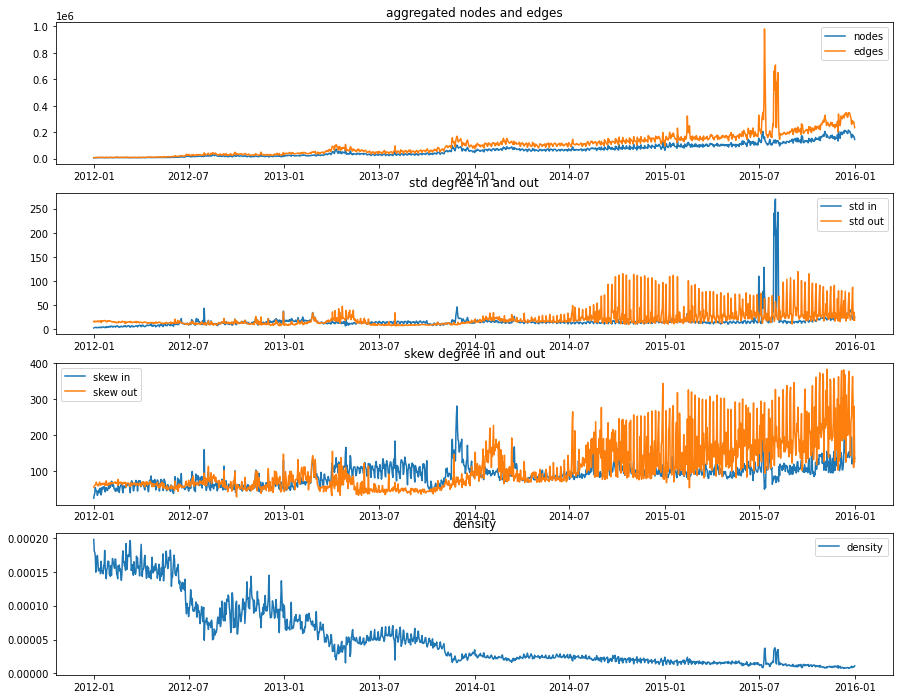

In [36]:
fig, ((ax1, ax2,ax3,ax4)) = plt.subplots(4, 1)
fig.set_size_inches(15,12)

ax1.plot(df["date"],df["g_nodes"], label="nodes")
ax1.plot(df["date"],df["g_edges"], label="edges")
ax1.legend()
ax1.set_title("aggregated nodes and edges")

ax2.plot(df["date"],df["std_in"], label="std in")
ax2.plot(df["date"],df["std_out"], label="std out")
ax2.legend()
ax2.set_title("std degree in and out")

ax3.plot(df["date"],df["skew_in"], label="skew in")
ax3.plot(df["date"],df["skew_out"], label="skew out")
ax3.legend()
ax3.set_title("skew degree in and out")

ax4.plot(df["date"],df["g_density"], label="density")
ax4.legend()
ax4.set_title("density")

plt.show()

In [64]:
df_rand1 = pd.read_json("results/randomized/2012-01-01_randomized.json",convert_dates=True)
df_rand2 = pd.read_json("results/randomized/2013-01-01_randomized.json",convert_dates=True)
df_rand3 = pd.read_json("results/randomized/2014-01-01_randomized.json",convert_dates=True)
df_rand4 = pd.read_json("results/randomized/2015-01-01_randomized.json",convert_dates=True)
df_rand5 = pd.read_json("results/randomized/2016-01-01_randomized.json",convert_dates=True)
df_rand6 = pd.read_json("results/randomized/2017-01-01_randomized.json",convert_dates=True)
df_rand7 = pd.read_json("results/randomized/2018-01-01_randomized.json",convert_dates=True)

In [72]:
df_rand1

,bowtie,stats,bowtie_random,stats_random
nodes,6114.0,NaN,6114.0,NaN
ssc,115.0,NaN,5273.0,NaN
in,1062.0,NaN,0.0,NaN
out,202.0,NaN,0.0,NaN
tubes,65.0,NaN,0.0,NaN
tendrils,3211.0,NaN,0.0,NaN
fringe,357.0,NaN,0.0,NaN
disconnected,1102.0,NaN,841.0,NaN
clustering,NaN,0.022651,NaN,0.035403
assortativity,NaN,-0.166781,NaN,-0.155987


In [128]:
data_rand = {
    "2012 basic":df_rand1["bowtie"][1:-2],
    "2012 random":df_rand2["bowtie_random"][1:-2],
    "2013 basic":df_rand2["bowtie"][1:-2],
    "2013 random":df_rand2["bowtie_random"][1:-2],
    "2014 basic":df_rand3["bowtie"][1:-2],
    "2014 random":df_rand3["bowtie_random"][1:-2],
    "2015 basic":df_rand4["bowtie"][1:-2],
    "2015 random":df_rand4["bowtie_random"][1:-2],
    "2016 basic":df_rand5["bowtie"][1:-2],
    "2016 random":df_rand5["bowtie_random"][1:-2],
    "2017 basic":df_rand6["bowtie"][1:-2],
    "2017 random":df_rand6["bowtie_random"][1:-2],
    "2018 basic":df_rand7["bowtie"][1:-2],
    "2018 random":df_rand7["bowtie_random"][1:-2]
}

df_rand = pd.DataFrame(data_rand)

data_stats = {
    "2012":df_rand1["stats"][-2:],
    "2013":df_rand2["stats"][-2:],
    "2014":df_rand3["stats"][-2:],
    "2015":df_rand4["stats"][-2:],
    "2016":df_rand5["stats"][-2:],
    "2017":df_rand6["stats"][-2:],
    "2018":df_rand7["stats"][-2:]
}

df_stats = pd.DataFrame(data_stats).transpose()

data_stats_random = {
    "2012":df_rand1["stats_random"][-2:],
    "2013":df_rand2["stats_random"][-2:],
    "2014":df_rand3["stats_random"][-2:],
    "2015":df_rand4["stats_random"][-2:],
    "2016":df_rand5["stats_random"][-2:],
    "2017":df_rand6["stats_random"][-2:],
    "2018":df_rand7["stats_random"][-2:]
}

df_random_stats = pd.DataFrame(data_stats_random).transpose()

combined_data = {
    "clustering_basic": df_stats["clustering"],
    "clustering_random": df_random_stats["clustering"],
    "assortativity_basic": df_stats["assortativity"],
    "assortativity_random": df_random_stats["assortativity"]
}

df_combined_stats = pd.DataFrame(combined_data)

In [85]:
df_rand

,2012 basic,2012 random,2013 basic,2013 random,2014 basic,2014 random,2015 basic,2015 random,2016 basic,2016 random,2017 basic,2017 random,2018 basic,2018 random
ssc,115.0,16708.0,1540.0,16708.0,11123.0,43534.0,10892.0,59347.0,30329.0,121806.0,28479.0,193326.0,48237.0,287507.0
in,1062.0,0.0,4310.0,0.0,9314.0,0.0,18492.0,0.0,26746.0,0.0,47588.0,0.0,94540.0,0.0
out,202.0,0.0,1220.0,0.0,8090.0,0.0,16940.0,0.0,41541.0,0.0,41522.0,0.0,46848.0,0.0
tubes,65.0,0.0,215.0,0.0,269.0,0.0,592.0,0.0,1725.0,0.0,5089.0,0.0,3312.0,0.0
tendrils,3211.0,0.0,5629.0,0.0,14093.0,0.0,11188.0,0.0,20031.0,0.0,56137.0,0.0,73057.0,0.0
fringe,357.0,0.0,2976.0,0.0,383.0,0.0,934.0,0.0,2354.0,0.0,8636.0,0.0,10209.0,0.0
disconnected,1102.0,1026.0,1844.0,1026.0,3186.0,2924.0,4200.0,3891.0,5737.0,6657.0,21599.0,15724.0,35249.0,23945.0


In [129]:
df_combined_stats

,clustering_basic,clustering_random,assortativity_basic,assortativity_random
2012,0.022651,0.035403,-0.166781,-0.155987
2013,0.063061,0.030981,-0.156981,-0.126557
2014,0.033727,0.027072,-0.117220,-0.120199
2015,0.032228,0.022612,-0.106500,-0.094014
2016,0.050004,0.041905,-0.108235,-0.102974
2017,0.037204,0.021994,-0.074280,-0.070054
2018,0.038701,0.052709,-0.129037,-0.125758
